In [1]:
import os, sys, time, math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import cma
from PIL import Image
import glob
import re


from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr

from gvxrPython3.utils import visualise # Visualise the 3D environment if k3D is supported
from gvxrPython3.utils import plotScreenshot # Visualise the 3D environment using Matplotlib

from gvxrPython3.utils import loadSpekpySpectrum # Generate and load an X-ray spectrum using Spekpy
from gvxrPython3.utils import loadXpecgenSpectrum # Generate and load an X-ray spectrum using xpecgen

spekpy is not install, you won't be able to load a beam spectrum using spekpy
xpecgen is not install, you won't be able to load a beam spectrum using xpecgen
SimpleGVXR 2.0.6 (2023-05-23T20:52:16) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 2.0.6 (2023-05-23T20:53:11) [Compiler: Microsoft Visual Studio] on Windows


In [2]:
# data_path = "C:/Users/user/phd/Dataoff/"
# data_path = "C:/Users/user/phd/26SepImages/"
# data_path = "C:/Users/snn23kfl/project/"
data_path = "C:/Users/snn23kfl/project/4thOCtober_image/"

In [3]:
current_folder = str(globals()['_dh'][0])
print(current_folder)

C:\Users\snn23kfl\project


In [4]:
def average_images(image_paths):
    
    """Average a list of images."""
    # Load the first image to get the shape
    sample_image = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)
    if sample_image is None:
        raise ValueError(f"Failed to load image: {image_paths[0]}")
    
    avg_image = np.zeros_like(sample_image, dtype=float)
    
    for path in image_paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Failed to load image: {path}")
        avg_image += image.astype(float)
    
    avg_image /= len(image_paths)
    
    return cv2.medianBlur(avg_image.astype(np.single), 3)

In [5]:
def flatField(img, white, dark, epsilon=0.0):

    temp_white = np.copy(white)
    temp_img = np.copy(img)
    
    test = white - dark == 0
    temp_white[test] += 1

    if len(img.shape) == 2:
        temp_img[test] += 1
        return (temp_img - dark + epsilon) / (temp_white - dark + epsilon)
    elif len(img.shape) == 3:
        flat = np.zeros(img.shape, dtype=np.single)
        for i, proj in enumerate(temp_img):
            proj[test] += 1
            flat[i] = (proj - dark + epsilon) / (temp_white - dark + epsilon)
        return flat
    else:
        raise IOError("Bad image dimension: " + str(img.shape))

In [6]:
def numerical_sort(file_path):
    # Extract the number from the filename using regex
    number = int(re.search(r'(\d+)', file_path).group(1))
    return number

In [7]:
#path for my recently acquired images stored in PhD file

dark_field_paths = sorted(glob.glob(data_path + '/darkfd/darkfd_*.tiff'),key=numerical_sort)
white_field_paths = sorted(glob.glob(data_path + '/whitefd/whitefd_*.tiff'),key=numerical_sort)
raw_image_paths = sorted(glob.glob(data_path + '/raw_images/raw_image_*.tiff'),key=numerical_sort)

if len(raw_image_paths) == 0:
    raw_image_paths = sorted(glob.glob(data_path + '/rawimages/raw_images_*.jpg'))

In [8]:
#Average the dark field and white field images
I_dark = average_images(dark_field_paths)
I_white = average_images(white_field_paths)

In [9]:
I_raw = []
for fname in raw_image_paths:
    I_raw.append(cv2.imread(fname, 
                           cv2.IMREAD_GRAYSCALE))
I_raw = np.array(I_raw)
# I_raw = average_images(raw_image_paths)

I_flat1 = flatField(I_raw, I_white, I_dark)
I_flat2 = flatField(I_raw, I_white, np.zeros(I_dark.shape))

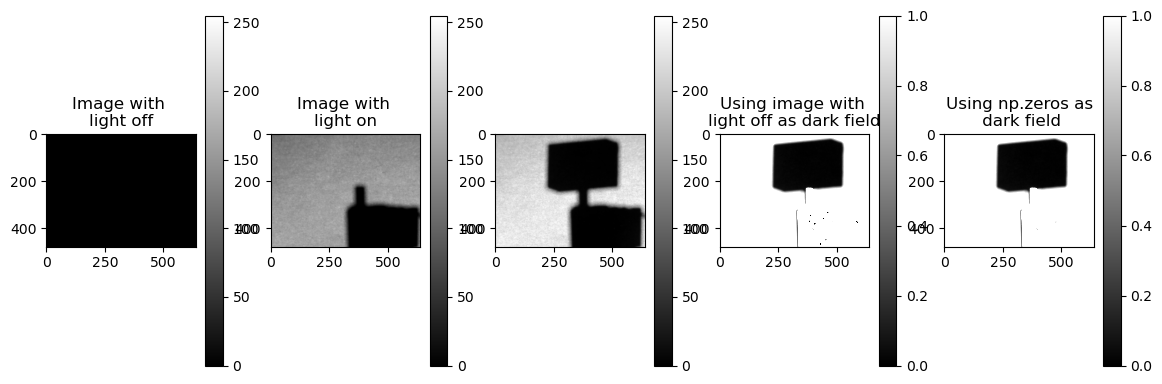

In [10]:
plt.figure(figsize=(14,10))
plt.subplot(2, 5, 1)
plt.title("Image with \nlight off")
plt.imshow(I_dark, cmap="gray", vmin=0, vmax=255)
plt.colorbar()

plt.subplot(2, 5, 2)
plt.title("Image with \nlight on")
plt.imshow(I_white, cmap="gray", vmin=0, vmax=255)
plt.colorbar()

if len(I_raw.shape) == 2:

    plt.subplot(2, 5, 3)
    plt.imshow(I_raw, cmap="gray", vmin=0, vmax=255)
    plt.colorbar()

    plt.subplot(2, 5, 4)
    plt.imshow(I_flat1, cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    
    plt.subplot(2, 5, 5)
    plt.imshow(I_flat2, cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
else:
    plt.subplot(2, 5, 3)
    plt.imshow(I_raw[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=255)
    plt.colorbar()

    plt.subplot(2, 5, 4)
    plt.title("Using image with \nlight off as dark field")
    plt.imshow(I_flat1[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=1)
    plt.colorbar()

    plt.subplot(2, 5, 5)
    plt.title("Using np.zeros as\n dark field")
    plt.imshow(I_flat2[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=1)
    plt.colorbar()


In [11]:
I_flat = I_flat2

In [12]:
#sod = 43
#sod =47
sod = 48
sdd = 61

In [13]:
Ti90Al10 = 5.68
x_src = 0
y_src = 0
z_src = sod

x_det = 0
y_det = 0
z_det = -(sdd - sod)

x_obj = 5
y_obj = 0
z_obj = 0

alpha_x = 0 
alpha_y = 0
alpha_z = 0

x_rot = 0
y_rot = 0
z_rot = 0

x_default = [
    x_src,
    y_src,
    z_src,

    x_det,
    y_det,
    z_det,

    x_obj,
    y_obj,
    z_obj,

#     alpha_x, 
#     alpha_y,
#     alpha_z,

#     x_rot,
#     y_rot,
#     z_rot,
]


In [14]:
# Initialise gVXR using our JSON file
json2gvxr.initGVXR("simulation1.json", "OPENGL", 3, 2)

Create an OpenGL context: 512x512


In [15]:
# Load our source properties
json2gvxr.initSourceGeometry("simulation1.json")
json2gvxr.initSpectrum(verbose=0)

gvxr.setSourcePosition(x_src, y_src, z_src, "mm")

Set up the beam
	Source position: [0.0, 0.0, 0.0, 'mm']
	Source shape: PointSource


In [16]:
def getAverageEnergy(k, f):
    
    avg = 0
    for energy, count in zip(k, f):
        avg += energy * count
        
    return avg / np.sum(f)

In [17]:
# Load our detector
json2gvxr.initDetector("simulation1.json")
    # "NumberOfPixels": [2880, 2880],

gvxr.setDetectorPosition(x_det, y_det, z_det, "mm")

Set up the detector
	Detector position: [0.0, 0.0, 0.0, 'mm']
	Detector up vector: [0, -1, 0]
	Number of pixels: [640, 480]
	Detector number of pixels: [640, 480]
	Pixel spacing: [0.23, 0.23, 'mm']


In [18]:
# Load our samples
json2gvxr.initSamples("simulation1.json", verbose=0)

gvxr.setDensity("cuboid", Ti90Al10, "g/cm3")

In [19]:
# ID = "cuboid"
# gvxr.rotateNode(ID, 90, 1.0, 0.0, 0.0)
# gvxr.moveToCentre()
# gvxr. applyCurrentLocalTransformation(ID)

# alpha_x = 0
# alpha_y = 0
# alpha_z = 0

# x_obj = 0
# y_obj = 0
# z_obj = 0

In [20]:
visualise()

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

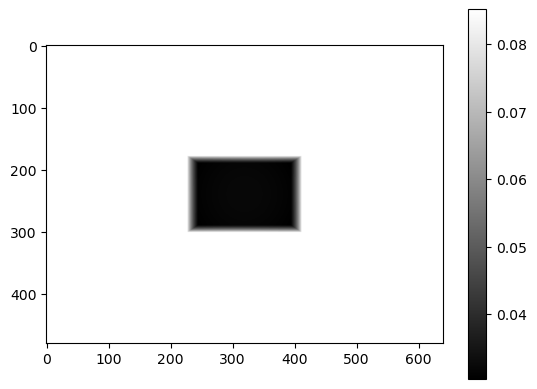

In [21]:
# Let's get an x-ray image
fig = plt.figure()
plt.imshow(gvxr.computeXRayImage(), cmap="gray")
plt.colorbar()
plt.show()

In [22]:
def getXrayImage(x):
    backup = gvxr.getLocalTransformationMatrix("root")

    # Move source, det, object using x
    x_src = x[0]
    y_src = x[1]
    z_src = x[2]
    gvxr.setSourcePosition(x_src, y_src, z_src, "mm")
    
    x_det = x[3]
    y_det = x[4]
    z_det = x[5]
    gvxr.setDetectorPosition(x_det, y_det, z_det, "mm")

    x_obj = x[6]
    y_obj = x[7]
    z_obj = x[8]
    gvxr.resetSceneTransformation();
    gvxr.translateNode("root", x_obj, y_obj, z_obj, "mm")
    
    test_image = np.array(gvxr.computeXRayImage(), dtype=np.single)
    
    gvxr.setLocalTransformationMatrix("root", backup)
    
    return test_image / gvxr.getTotalEnergyWithDetectorResponse()

In [23]:
def compare(ref, test):
    return np.abs(ref - test).mean()


# I_flat -= I_flat.mean()
# I_flat /= I_flat.std()

def fitness(x):
    test_image = getXrayImage(x)
    test_image -= test_image.mean()
    test_image /= test_image.std()

    fitness_value = compare(I_flat, test_image)
    return fitness_value

In [24]:
def displayResult(x):
    test_image = getXrayImage(x)
    
    ref_tmp = np.copy(I_flat)
    test_tmp = np.copy(test_image)
    
#     ref_tmp -= ref_tmp.mean()
#     ref_tmp /= ref_tmp.std()

#     test_tmp -= test_tmp.mean()
#     test_tmp /= test_tmp.std()

    ZNCC = 100 * (ref_tmp / test_tmp).mean()
    print("Overall ZNCC:", "{:.4f}".format(ZNCC) + "%")
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    plt.suptitle("ZNCC=" + "{:.4f}".format(ZNCC) + "%")
    axs[0].imshow(I_flat[0], cmap="gray", vmin=0, vmax=1)
#   axs[0].imshow(I_flat,cmap="gray", vmin=0, vmax=1)
    axs[1].imshow(test_image,cmap="gray", vmin=0, vmax=1)
    im = axs[2].imshow((I_flat[0] - test_image),cmap="gray", vmin=-1, vmax=1)

#    im = axs[2].imshow((I_flat - test_image),cmap="gray", vmin=-1, vmax=1)
    cbar = fig.colorbar(im)

#     for ax in axs:
#         ax.set_xlim([100, 600])
#         ax.set_ylim([211, 470])
#    plt.savefig('x_default.jpg', dpi=300, bbox_inches='tight')

    plt.show()    

Overall ZNCC: 249.4989%


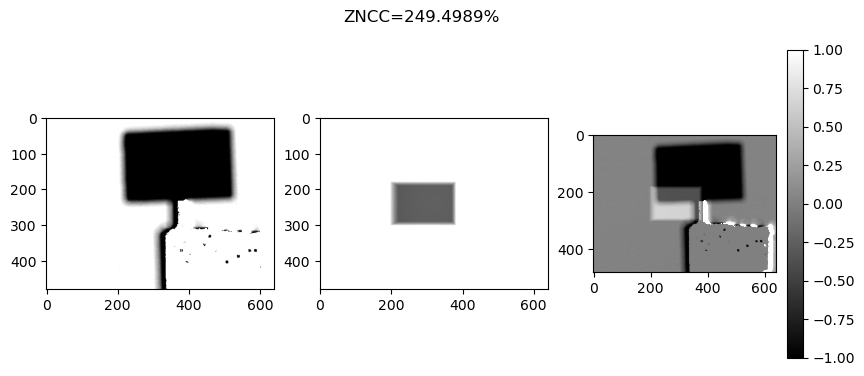

In [25]:
# %matplotlib notebook

displayResult(x_default)

In [26]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-2);
opts['tolx'] = 1e-2;
opts['bounds'] = [9*[-50], 9*[50]];

if True:#not os.path.exists(current_folder + "/x_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_default, 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best1 = es.result.xbest
    np.savetxt(current_folder + "/x_best1.dat", x_best1)
else:
    x_best1 = np.loadtxt(current_folder + "/x_best1.dat")
    


(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=520544, Wed Oct  4 21:10:56 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.427189588546753e+00 1.0e+00 5.15e-01  5e-01  5e-01 0:01.9


In [27]:
print(x_best1)

[  0.42072357  -1.19825597  48.14381158  -0.91794598  -1.08962163
 -12.78452781   4.64901156   0.57413716  -0.2239525 ]


Overall ZNCC: 247.2839%


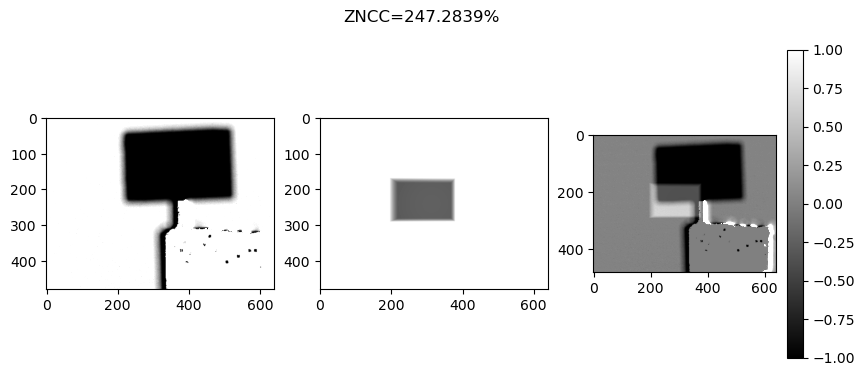

In [28]:
displayResult(x_best1)

In [29]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-2);
opts['tolx'] = 1e-2;
opts['bounds'] = [9*[-51], 9*[51]];

if True:#not os.path.exists(current_folder + "/x_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_best1, 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best2 = es.result.xbest
    np.savetxt(current_folder + "/x_best2.dat", x_best2)
else:
    x_best2 = np.loadtxt(current_folder + "/x_best2.dat")
    

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=478306, Wed Oct  4 21:10:59 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.425763607025146e+00 1.0e+00 4.69e-01  5e-01  5e-01 0:01.8


Overall ZNCC: 247.9761%


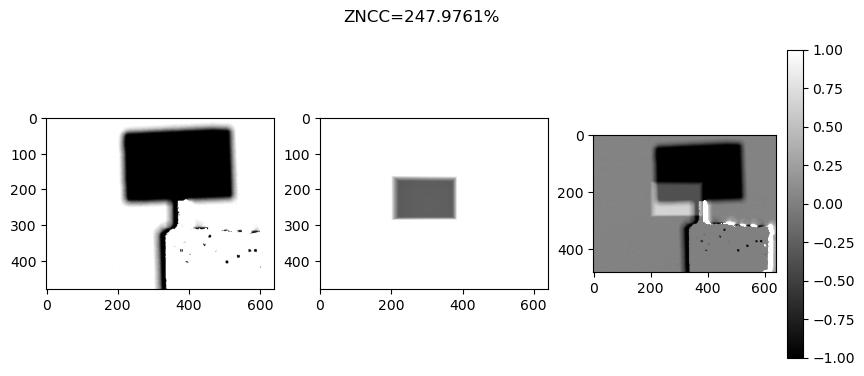

In [30]:
displayResult(x_best2)

In [31]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-2);
opts['tolx'] = 1e-2;
opts['bounds'] = [9*[-53], 9*[53]];

if True:#not os.path.exists(current_folder + "/x_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_best2, 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best3 = es.result.xbest
    np.savetxt(current_folder + "/x_best3.dat", x_best2)
else:
    x_best3 = np.loadtxt(current_folder + "/x_best3.dat")

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=566344, Wed Oct  4 21:11:01 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.423529386520386e+00 1.0e+00 5.17e-01  5e-01  5e-01 0:02.0


Overall ZNCC: 247.5874%


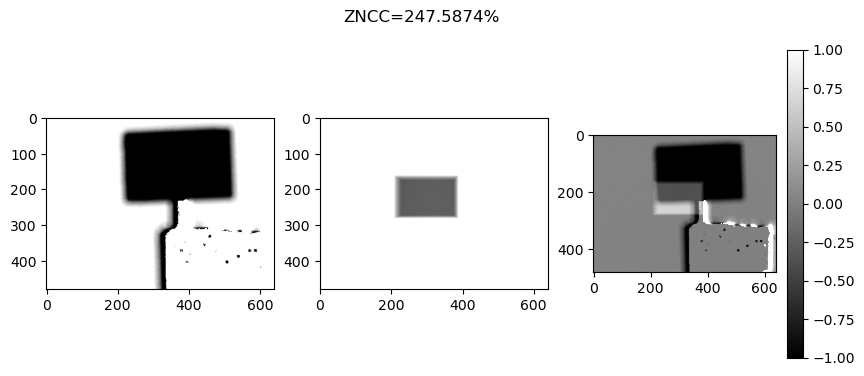

In [32]:
displayResult(x_best3)

In [33]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-2);
opts['tolx'] = 1e-2;
opts['bounds'] = [9*[-60], 9*[60]];

if True:#not os.path.exists(current_folder + "/x_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_best3, 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best4 = es.result.xbest
    np.savetxt(current_folder + "/x_best4.dat", x_best4)
else:
    x_best4 = np.loadtxt(current_folder + "/x_best4.dat")

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=549533, Wed Oct  4 21:11:04 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.422163248062134e+00 1.0e+00 4.78e-01  5e-01  5e-01 0:02.1


In [34]:
print(x_best4)

[ -0.69694439  -1.27616186  48.40514643  -0.17170407  -3.33906735
 -11.86313234   3.28463284   1.21890731  -0.19547177]


Overall ZNCC: 246.5106%


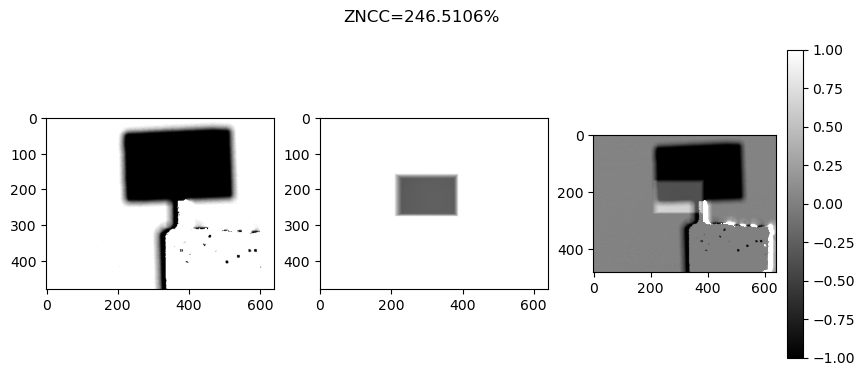

In [35]:
displayResult(x_best4)

In [36]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-2);
opts['tolx'] = 1e-2;
opts['bounds'] = [9*[-85], 9*[85]];

if True:#not os.path.exists(current_folder + "/x_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_best4, 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best5 = es.result.xbest
    np.savetxt(current_folder + "/x_best5.dat", x_best5)
else:
    x_best5 = np.loadtxt(current_folder + "/x_best5.dat")

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=482687, Wed Oct  4 21:11:07 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.420644044876099e+00 1.0e+00 4.54e-01  4e-01  5e-01 0:02.0


Overall ZNCC: 252.9372%


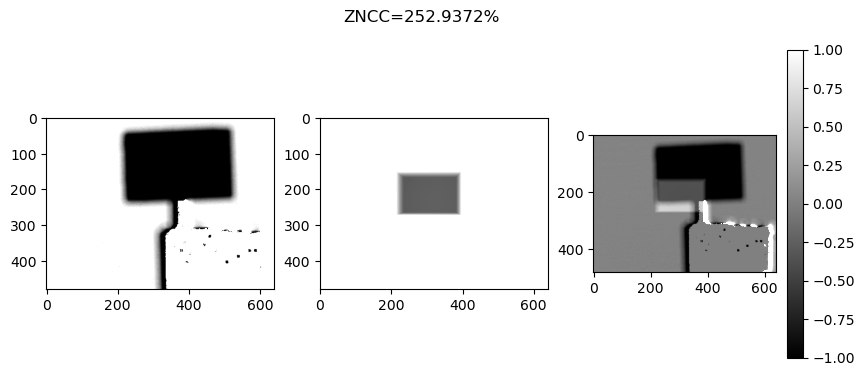

In [37]:
displayResult(x_best5)

In [38]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-2);
opts['tolx'] = 1e-2;
opts['bounds'] = [9*[-200], 9*[200]];

if True:#not os.path.exists(current_folder + "/x_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_best5, 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best6 = es.result.xbest
    np.savetxt(current_folder + "/x_best6.dat", x_best6)
else:
    x_best6 = np.loadtxt(current_folder + "/x_best6.dat")

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=564721, Wed Oct  4 21:11:09 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.418682813644409e+00 1.0e+00 4.89e-01  5e-01  5e-01 0:02.0


Overall ZNCC: 255.0459%


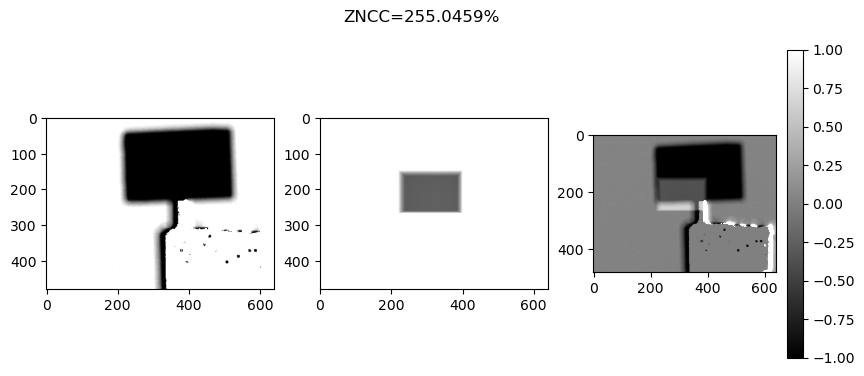

In [39]:
displayResult(x_best6)

In [43]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-2);
opts['tolx'] = 1e-2;
opts['bounds'] = [9*[-300], 9*[300]];

if True:#not os.path.exists(current_folder + "/x_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_best6, 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best7 = es.result.xbest
    np.savetxt(current_folder + "/x_best7.dat", x_best7)
else:
    x_best7 = np.loadtxt(current_folder + "/x_best7.dat")

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=541263, Wed Oct  4 21:19:47 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.415717363357544e+00 1.0e+00 5.69e-01  6e-01  6e-01 0:02.0


Overall ZNCC: 250.1160%


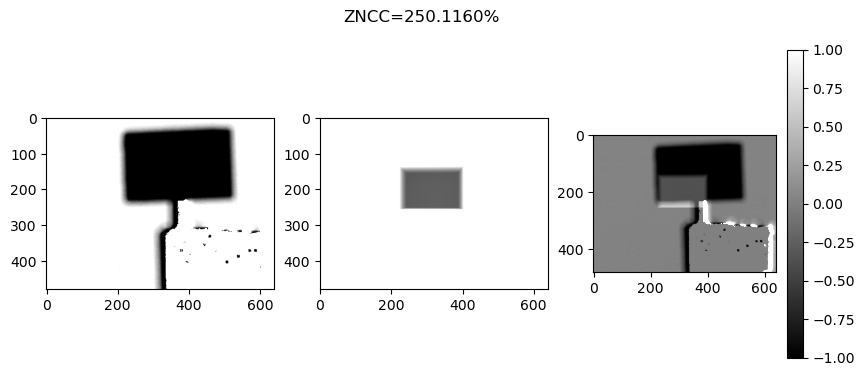

In [44]:
displayResult(x_best7)

In [45]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-2);
opts['tolx'] = 1e-2;
opts['bounds'] = [9*[-300], 9*[300]];

if True:#not os.path.exists(current_folder + "/x_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_best7, 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best8 = es.result.xbest
    np.savetxt(current_folder + "/x_best8.dat", x_best8)
else:
    x_best8 = np.loadtxt(current_folder + "/x_best8.dat")

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=565841, Wed Oct  4 21:20:12 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.413691759109497e+00 1.0e+00 5.08e-01  5e-01  5e-01 0:01.8


Overall ZNCC: 243.8153%


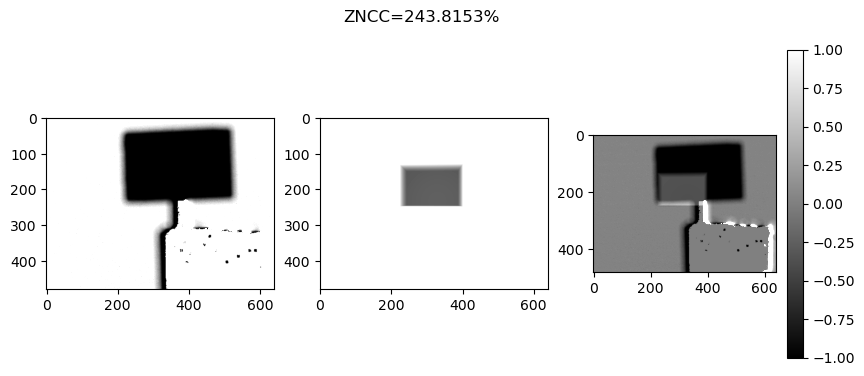

In [46]:
displayResult(x_best8)

In [47]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-2);
opts['tolx'] = 1e-2;
opts['bounds'] = [9*[-300], 9*[300]];

if True:#not os.path.exists(current_folder + "/x_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_best8, 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best9 = es.result.xbest
    np.savetxt(current_folder + "/x_best9.dat", x_best9)
else:
    x_best9 = np.loadtxt(current_folder + "/x_best9.dat")

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=536891, Wed Oct  4 21:21:19 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.411549568176270e+00 1.0e+00 5.51e-01  5e-01  6e-01 0:02.1


Overall ZNCC: 241.3979%


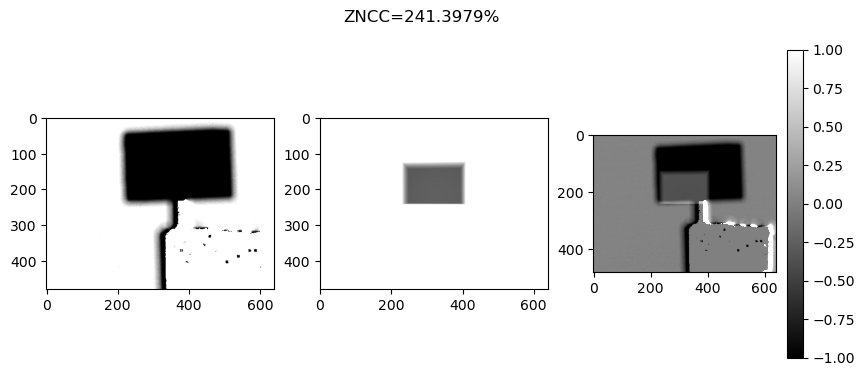

In [48]:
displayResult(x_best9)

In [49]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-2);
opts['tolx'] = 1e-2;
opts['bounds'] = [9*[-400], 9*[400]];

if True:#not os.path.exists(current_folder + "/x_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_best9, 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best10 = es.result.xbest
    np.savetxt(current_folder + "/x_best10.dat", x_best10)
else:
    x_best10 = np.loadtxt(current_folder + "/x_best10.dat")

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=540776, Wed Oct  4 21:22:39 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.409319400787354e+00 1.0e+00 4.87e-01  5e-01  5e-01 0:02.1


Overall ZNCC: 238.9259%


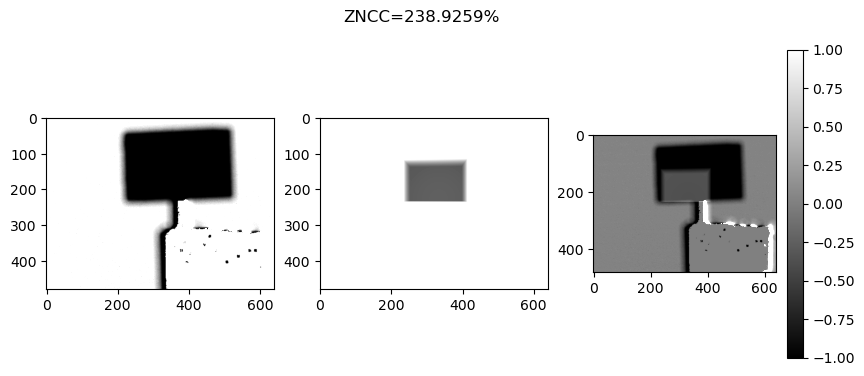

In [50]:
displayResult(x_best10)

In [52]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-2);
opts['tolx'] = 1e-2;
opts['bounds'] = [9*[-400], 9*[400]];

if True:#not os.path.exists(current_folder + "/x_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_best10, 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best11 = es.result.xbest
    np.savetxt(current_folder + "/x_best11.dat", x_best11)
else:
    x_best11 = np.loadtxt(current_folder + "/x_best11.dat")

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=533985, Wed Oct  4 21:23:58 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.408875703811646e+00 1.0e+00 4.81e-01  5e-01  5e-01 0:02.1


Overall ZNCC: 238.6975%


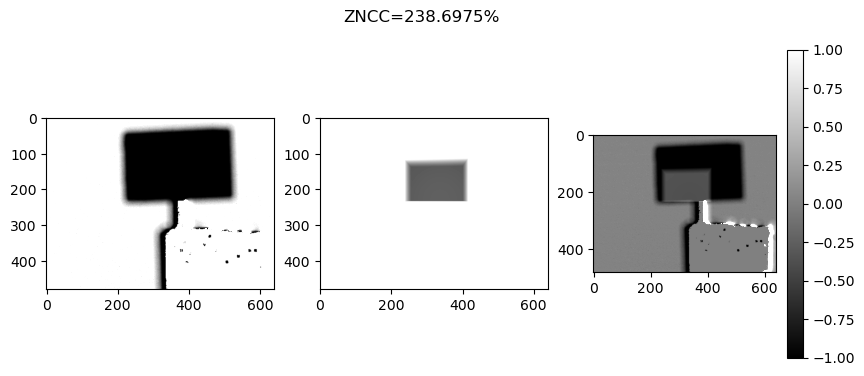

In [53]:
displayResult(x_best11)